In [69]:
import pandas as pd

# Replace 'your_clickbait_dataset.csv' with the path to your dataset
dataset = pd.read_csv('clickbait_dataset.csv')

# Turn the clickbait column into a boolean column
dataset['clickbait'] = dataset['clickbait'].astype(bool)

# Display information about the dataset
print(dataset.head())

                                            headline  clickbait
0                                 Should I Get Bings       True
1      Which TV Female Friend Group Do You Belong In       True
2  The New "Star Wars: The Force Awakens" Trailer...       True
3  This Vine Of New York On "Celebrity Big Brothe...       True
4  A Couple Did A Stunning Photo Shoot With Their...       True


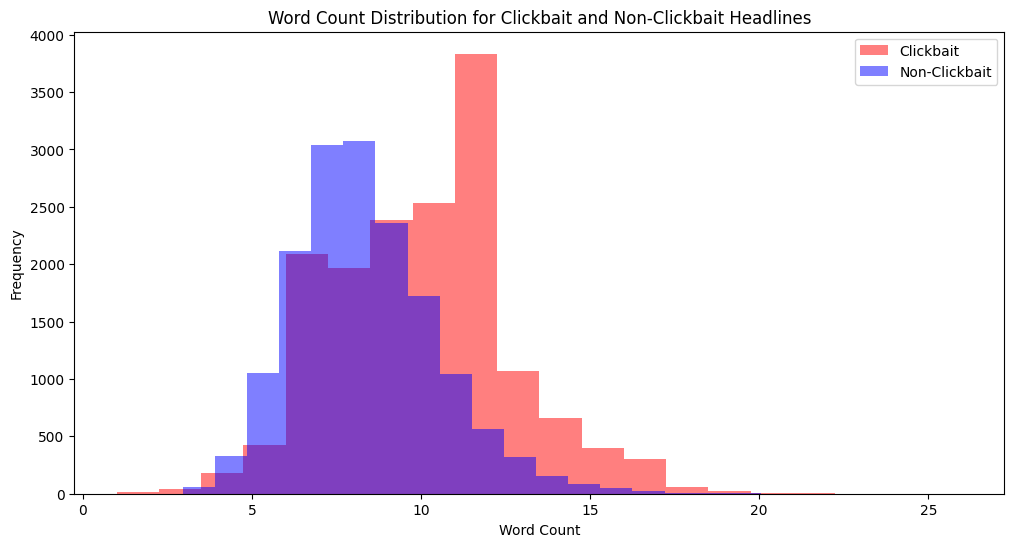

In [70]:
import matplotlib.pyplot as plt

# Add a new column for word count
dataset['word_count'] = dataset['headline'].apply(lambda x: len(x.split()))

# Separate the data into clickbait and non-clickbait
clickbait_data = dataset[dataset['clickbait'] == True]
non_clickbait_data = dataset[dataset['clickbait'] == False]

# Plot the word count distribution
plt.figure(figsize=(12, 6))
plt.hist(clickbait_data['word_count'], alpha=0.5, bins=20, label='Clickbait', color='red')
plt.hist(non_clickbait_data['word_count'], alpha=0.5, bins=20, label='Non-Clickbait', color='blue')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution for Clickbait and Non-Clickbait Headlines')
plt.legend()
plt.show()

In [71]:
def calculate_features(headline):
    features = {}
    # F1: Check whether the first word of a news headline is a number.
    features['F1'] = 1 if headline.split()[0].isdigit() else 0
    # F2: Calculate the number of exclamation marks in a news title.
    features['F2'] = headline.count('!')
    # F3: Calculate the number of brackets in news titles.
    features['F3'] = headline.count('(') + headline.count(')')
    # F4: Calculate the number of quotation marks in news titles.
    features['F4'] = headline.count('"')
    # F5: Check for colons in news titles.
    features['F5'] = 1 if ':' in headline else 0
    # F6: Check for ellipsis marks in news titles.
    features['F6'] = 1 if '...' in headline else 0
    # F7: Check for numeric symbols in news titles.
    features['F7'] = 1 if any(char.isdigit() for char in headline) else 0
    # F8: Word count of the title.
    features['F8'] = len(headline.split())
    # F9: Number of question marks in the title.
    features['F9'] = headline.count('?')
    return features

# Apply the function to each headline in the dataset
features_df = dataset['headline'].apply(calculate_features).apply(pd.Series)

# Concatenate the original dataset with the new features
dataset = pd.concat([dataset, features_df], axis=1)

# Display the updated dataset with new features
print(dataset.head())

                                            headline  clickbait  word_count  \
0                                 Should I Get Bings       True           4   
1      Which TV Female Friend Group Do You Belong In       True           9   
2  The New "Star Wars: The Force Awakens" Trailer...       True          14   
3  This Vine Of New York On "Celebrity Big Brothe...       True          12   
4  A Couple Did A Stunning Photo Shoot With Their...       True          18   

   F1  F2  F3  F4  F5  F6  F7  F8  F9  
0   0   0   0   0   0   0   0   4   0  
1   0   0   0   0   0   0   0   9   0  
2   0   0   0   2   1   0   0  14   0  
3   0   0   0   2   0   0   0  12   0  
4   0   0   0   0   0   0   0  18   0  


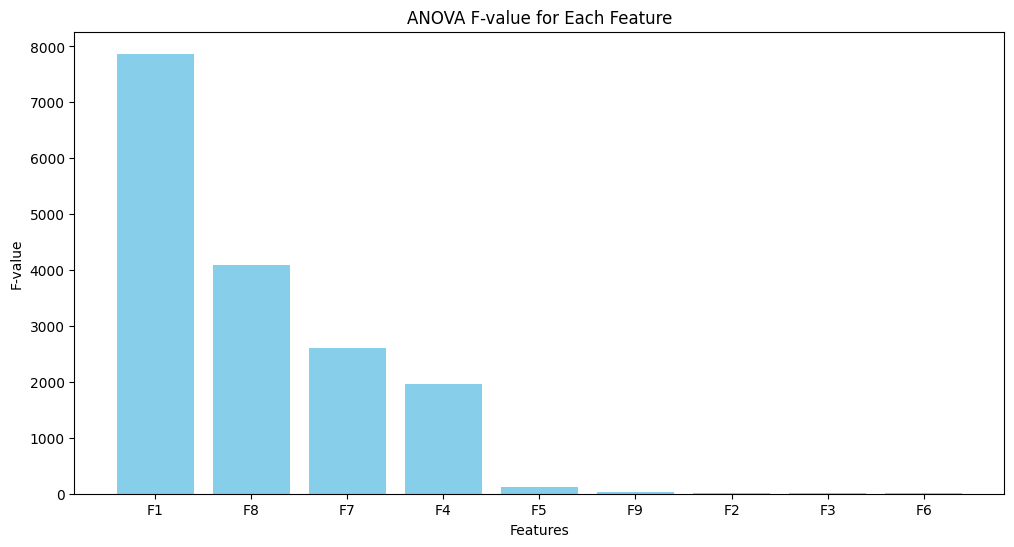

                                            headline  clickbait  word_count  \
0                                 Should I Get Bings       True           4   
1      Which TV Female Friend Group Do You Belong In       True           9   
2  The New "Star Wars: The Force Awakens" Trailer...       True          14   
3  This Vine Of New York On "Celebrity Big Brothe...       True          12   
4  A Couple Did A Stunning Photo Shoot With Their...       True          18   

   F1  F2  F4  F5  F7  F8  F9  
0   0   0   0   0   0   4   0  
1   0   0   0   0   0   9   0  
2   0   0   2   1   0  14   0  
3   0   0   2   0   0  12   0  
4   0   0   0   0   0  18   0  


In [72]:
from sklearn.feature_selection import f_classif
import numpy as np

# Extract the feature columns
feature_columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']
X = dataset[feature_columns]
y = dataset['clickbait']

# Perform ANOVA
F_values, p_values = f_classif(X, y)

# Create a DataFrame to display the F-values
anova_results = pd.DataFrame({'Feature': feature_columns, 'F_value': F_values})
anova_results = anova_results.sort_values(by='F_value', ascending=False)

# Plot the F-values
plt.figure(figsize=(12, 6))
plt.bar(anova_results['Feature'], anova_results['F_value'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('F-value')
plt.title('ANOVA F-value for Each Feature')
plt.show()

# Identify features with the five lowest F-values
features_to_remove = anova_results.nsmallest(2, 'F_value')['Feature'].tolist()

# Remove the identified features from the dataset
dataset = dataset.drop(columns=features_to_remove)

# Display the updated dataset with important features
print(dataset.head())

In [73]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 10000
max_len = 100
embedding_dim = 100

# Tokenizer erstellen und auf Daten fitten
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dataset['headline'])

# Daten vorbereiten
sequences = tokenizer.texts_to_sequences(dataset['headline'])
padded = pad_sequences(sequences, maxlen=max_len)

# Modell definieren
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(input_layer)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
lstm_layer = LSTM(128)(embedding_layer)
concatenated_layer = Concatenate()([pooling_layer, lstm_layer])
dense_layer = Dense(64, activation='relu')(concatenated_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell trainieren
model.fit(padded, dataset['clickbait'], epochs=5, batch_size=32, validation_split=0.2)

# Modell evaluieren
loss, accuracy = model.evaluate(padded, dataset['clickbait'])
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5


c:\Users\NWERTHM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


800/800 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.9025 - loss: 0.1991 - val_accuracy: 0.9305 - val_loss: 0.1809
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.9943 - loss: 0.0188 - val_accuracy: 0.9752 - val_loss: 0.0733
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.9987 - loss: 0.0047 - val_accuracy: 0.9523 - val_loss: 0.1808
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.9992 - loss: 0.0020 - val_accuracy: 0.9591 - val_loss: 0.1890
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9658 - val_loss: 0.1685
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9992 - loss: 0.0036
Loss: 0.03392012417316437, Accuracy: 0.9931250214576721


In [80]:
# Load the validation dataset
validation_dataset = pd.read_csv('validation_dataset.csv')

# Preprocess the validation data
validation_sequences = tokenizer.texts_to_sequences(validation_dataset['headline'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_len)

# Make predictions on the validation data
validation_predictions = model.predict(validation_padded)

# Convert predictions to binary labels
validation_predictions_binary = (validation_predictions > 0.5).astype(int).flatten()

# Calculate the quantiles
quantiles = pd.cut(validation_predictions.flatten(), bins=[i/10 for i in range(11)], labels=[f'{i/10}-{(i+1)/10}' for i in range(10)], include_lowest=True)

# Create a DataFrame to display the count of values in each quantile
quantile_counts = pd.DataFrame({'Quantile': quantiles, 'Count': 1}).groupby('Quantile').count().reset_index()

# Display the quantile counts
print(quantile_counts)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
validation_accuracy = accuracy_score(validation_dataset['clickbait'], validation_predictions_binary)
print(f'Validation Accuracy: {validation_accuracy:.4f}')

# Print classification report
print(classification_report(validation_dataset['clickbait'], validation_predictions_binary))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
  Quantile  Count
0  0.0-0.1  15666
1  0.1-0.2     45
2  0.2-0.3     31
3  0.3-0.4     22
4  0.4-0.5     17
5  0.5-0.6     17
6  0.6-0.7     19
7  0.7-0.8     21
8  0.8-0.9     36
9  0.9-1.0  16126
Validation Accuracy: 0.9931
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     16001
           1       0.99      1.00      0.99     15999

    accuracy                           0.99     32000
   macro avg       0.99      0.99      0.99     32000
weighted avg       0.99      0.99      0.99     32000



C:\Users\NWERTHM\AppData\Local\Temp\ipykernel_2744\470384398.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_counts = pd.DataFrame({'Quantile': quantiles, 'Count': 1}).groupby('Quantile').count().reset_index()
